In [1]:
import numpy as np
import matplotlib.pyplot as plt

# prediction vectors: shape is (n_samples, 2) of long/lat displacements in degrees
train_preds = np.load("/g/data/x77/jm0124/feature_vectors/feature-array-outputs-uv-train.npy")[:,[0,1]]
val_preds   = np.load("/g/data/x77/jm0124/feature_vectors/feature-array-outputs-uv-val.npy")  [:,[0,1]]
test_preds  = np.load("/g/data/x77/jm0124/feature_vectors/feature-array-outputs-uv-test.npy") [:,[0,1]]

def wrap_longitude(long: float) -> float:
    return (long + 180) % 360 - 180

import json
def load_labels(f):
    with open(f, 'r') as f2:
        j = json.load(f2)
    ids = j.keys()
    labels = []
    latent = []
    for id_ in ids:
        # JSON object has label: [[long_old, long_new], [lat_old, lat_new], [inten, inten]],
        # time: int, index: int
        long, lat, inten = j[id_]['label']
        labels.append([wrap_longitude(long[1] - long[0]), lat[1] - lat[0]])
        latent.append([wrap_longitude(long[0]), lat[0], inten[0]])
    return np.array(labels), np.array(latent)

# Latent stores associated lists of [old_long, old_lat, intensity]
train_labels, train_latent = load_labels("/g/data/x77/jm0124/feature_vectors/train_feature_labels.json")
val_labels,   val_latent   = load_labels("/g/data/x77/jm0124/feature_vectors/val_feature_labels.json")
test_labels,  test_latent  = load_labels("/g/data/x77/jm0124/feature_vectors/test_feature_labels.json")

In [2]:
np.save("/g/data/x77/ob2720/arrays/train_labels.npy", train_labels)
np.save("/g/data/x77/ob2720/arrays/train_preds.npy", train_preds)
np.save("/g/data/x77/ob2720/arrays/train_latent.npy", train_latent)
np.save("/g/data/x77/ob2720/arrays/val_labels.npy", val_labels)
np.save("/g/data/x77/ob2720/arrays/val_preds.npy", val_preds)
np.save("/g/data/x77/ob2720/arrays/val_latent.npy", val_latent)
np.save("/g/data/x77/ob2720/arrays/test_labels.npy", test_labels)
np.save("/g/data/x77/ob2720/arrays/test_preds.npy", test_preds)
np.save("/g/data/x77/ob2720/arrays/test_latent.npy", test_latent)

In [3]:
assert train_preds.shape == train_labels.shape
assert val_preds.shape == val_labels.shape
assert test_preds.shape == test_labels.shape

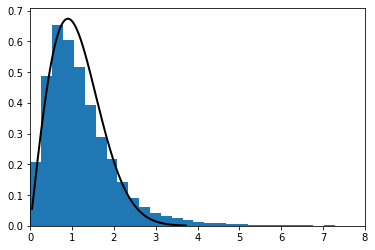

In [4]:
# plot distribution of magnitudes, it's Rayleigh distributed
from scipy.stats import rayleigh
x = np.linspace(rayleigh.ppf(0.001), rayleigh.ppf(0.999), 1000)
plt.plot(x, rayleigh.pdf(x, scale=0.9),'k-',lw=2)
R = (test_labels - test_preds)
mag = np.sqrt(R[:,0]**2 + R[:,1]**2)
mag = mag[mag < 300]
plt.hist(mag, bins=60, density=True)
plt.xlim(0,8)
None

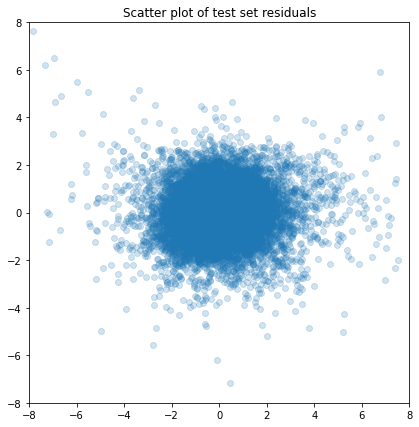

In [5]:
# plot global
plt.scatter(R[:,0], R[:,1], alpha=0.2)
plt.title("Scatter plot of test set residuals")
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().axis(xmin=-8, xmax=8, ymin=-8, ymax=8)
plt.gcf().set_size_inches(7, 7)

In [6]:
from enum import IntEnum
class Hemisphere(IntEnum):
    South = 0
    North = 1
    def __repr__(self):
        if self == Hemisphere.North: return "North"
        elif self == Hemisphere.South: return "South"

from collections import defaultdict
def bin_by_intensity_and_hemi(preds, true, latent):
    # returns a (default)dict where keys are intensities and values
    # are lists of (pred, true, latent) tuples where each is an ndarray
    bins = defaultdict(list)
    for i in range(len(preds)):
        inten = latent[i,2]
        hemi = Hemisphere.South if latent[i][1] < 0 else Hemisphere.North # latent[i][1] is the start latitude
        bins[(inten, hemi)].append((preds[i],true[i],latent[i]))
    return bins

train_bins = bin_by_intensity_and_hemi(train_preds, train_labels, train_latent)
val_bins   = bin_by_intensity_and_hemi(val_preds,   val_labels,   val_latent  )
test_bins  = bin_by_intensity_and_hemi(test_preds,  test_labels,  test_latent )

In [7]:
# Counting timesteps
buckets = sorted(train_bins.keys())
for key in buckets:
    print(f"{key}: {len(train_bins[key])}")

(-5.0, South): 10287
(-5.0, North): 10718
(-4.0, South): 268
(-4.0, North): 1732
(-3.0, South): 1562
(-3.0, North): 7156
(-2.0, South): 325
(-2.0, North): 588
(-1.0, South): 13663
(-1.0, North): 29697
(0.0, South): 16620
(0.0, North): 35708
(1.0, South): 4444
(1.0, North): 12743
(2.0, South): 2230
(2.0, North): 6013
(3.0, South): 1805
(3.0, North): 4640
(4.0, South): 1227
(4.0, North): 4161
(5.0, South): 141
(5.0, North): 958


In [8]:
# Getting sample covariance for each bucket
train_res = defaultdict(list)
train_cov = defaultdict(list)
for key in buckets:
    longlat_residuals = np.array([t[1]-t[0] for t in train_bins[key]])
    train_res[key] = longlat_residuals
    train_cov[key] = np.cov(longlat_residuals.T)

val_res = defaultdict(list)
val_cov = defaultdict(list)
for key in buckets:
    longlat_residuals = np.array([t[1]-t[0] for t in val_bins[key]])
    val_res[key] = longlat_residuals
    val_cov[key] = np.cov(longlat_residuals.T)

test_res = defaultdict(list)
test_cov = defaultdict(list)
for key in buckets:
    longlat_residuals = np.array([t[1]-t[0] for t in test_bins[key]])
    test_res[key] = longlat_residuals
    test_cov[key] = np.cov(longlat_residuals.T)

for key in buckets:
    cov = train_cov[key].tolist()
    print(f"{key}: [[{cov[0][0]:.3f}, {cov[0][1]:.3f}], [{cov[1][0]:.3f}, {cov[1][1]:.3f}]]")

(-5.0, South): [[0.650, -0.052], [-0.052, 0.413]]
(-5.0, North): [[0.933, 0.024], [0.024, 0.403]]
(-4.0, South): [[0.793, -0.179], [-0.179, 0.547]]
(-4.0, North): [[1.863, 0.133], [0.133, 0.580]]
(-3.0, South): [[0.301, -0.017], [-0.017, 0.257]]
(-3.0, North): [[0.292, 0.014], [0.014, 0.241]]
(-2.0, South): [[0.462, -0.079], [-0.079, 0.291]]
(-2.0, North): [[0.541, 0.055], [0.055, 0.281]]
(-1.0, South): [[0.346, -0.029], [-0.029, 0.277]]
(-1.0, North): [[0.327, 0.022], [0.022, 0.261]]
(0.0, South): [[0.344, -0.038], [-0.038, 0.277]]
(0.0, North): [[0.340, 0.042], [0.042, 0.238]]
(1.0, South): [[0.304, -0.039], [-0.039, 0.234]]
(1.0, North): [[0.335, 0.031], [0.031, 0.220]]
(2.0, South): [[0.308, -0.029], [-0.029, 0.221]]
(2.0, North): [[0.288, 0.041], [0.041, 0.201]]
(3.0, South): [[0.251, -0.035], [-0.035, 0.210]]
(3.0, North): [[0.223, 0.028], [0.028, 0.182]]
(4.0, South): [[0.219, -0.029], [-0.029, 0.171]]
(4.0, North): [[0.194, 0.031], [0.031, 0.168]]
(5.0, South): [[0.186, -0.045]

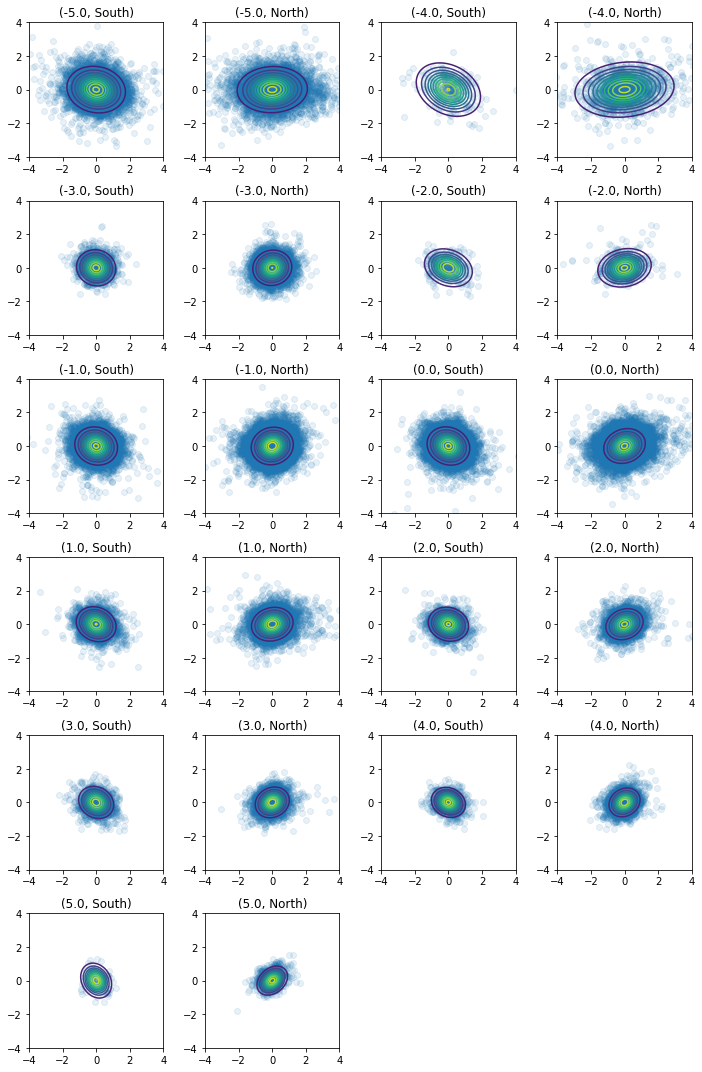

In [9]:
# Plotting samples on top of a N(0, sample_cov) contour
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy.stats import multivariate_normal
import math

def plot_bucket(ax, key):
    ax.axis(xmin=-4, xmax=4, ymin=-4, ymax=4)
    ax.set_aspect('equal', adjustable='box')
    # contour
    x, y = np.mgrid[-10:10:.05, -10:10:.05]
    rv = multivariate_normal([0, 0], train_cov[key])
    data = np.dstack((x, y))
    z = rv.pdf(data)
    ax.contour(x, y, z, levels=10)
    # scatter the points
    x, y = train_res[key].T
    ax.scatter(x, y, alpha=0.1)
    ax.set_title(key)

fig = plt.figure(figsize=(10, 15))
gs  = gridspec.GridSpec(6, 4)
fig.subplots_adjust(top=0.85)

for gs_, key in zip(gs, buckets):
    ax = plt.subplot(gs_)
    plot_bucket(ax, key)
fig.tight_layout()
plt.savefig("binned_distributions.png")
plt.show()

Log likelihood using our refined covariance estimates and the global sample covariance of the training, validation and test sets

In [10]:
import math
def log_zeromean_multivariate_normal_pdf(x, cov):
    k = cov.shape[0]
    return -0.5 * (k * math.log(2*math.pi) + math.log(np.linalg.det(cov)) + x.T @ np.linalg.pinv(cov) @ x)

def log_likelihood(preds, cov):
    p_values = []
    for x in preds:
        p_values.append(log_zeromean_multivariate_normal_pdf(x, cov))
    return sum(p_values)

In [11]:
# training a linear regressor to estimate covariance matrices

# covariance function
# takes a vector of parameters and latent variables to compute
# cov[residuals|latent]
def pred_cov(p, latent):
    # latent = [old_long, old_lat, old_intensity]
    # p = vector of parameters
    w, b = p[0:3], p[3:6]
    a, b, c = (w @ latent + b).tolist()
    return np.array([[a,b],[b,c]])

In [12]:
global_cov = np.cov((train_labels - train_preds).T)
global_cov

array([[0.39814131, 0.010389  ],
       [0.010389  , 0.26788336]])

In [13]:
def likelihood_stats(res, cov, labels, preds):
    def gm(a): return math.exp(a / labels.shape[0])
    refined_log_likelihood = sum([log_likelihood(res[key], cov[key]) for key in buckets])
    print(f"Log likelihood = {refined_log_likelihood} (GM {gm(refined_log_likelihood):.5%}) using binned sample covariances from training set")
    global_log_likelihood = sum([log_likelihood(res[key], global_cov) for key in buckets])
    print(f"Log likelihood = {global_log_likelihood} (GM {gm(global_log_likelihood):.5%}) using global sample covariance from training set")

print("Training set")
likelihood_stats(train_res, train_cov, train_labels, train_preds)
print("Validation set")
likelihood_stats(val_res, train_cov, val_labels, val_preds)
print("Test set")
likelihood_stats(test_res, train_cov, test_labels, test_preds)


Training set
Log likelihood = -275934.00127882126 (GM 19.10133%) using binned sample covariances from training set
Log likelihood = -286736.895011876 (GM 17.90264%) using global sample covariance from training set
Validation set
Log likelihood = -79325.92225483751 (GM 2.33863%) using binned sample covariances from training set
Log likelihood = -80679.30039445811 (GM 2.19348%) using global sample covariance from training set
Test set
Log likelihood = -84599.29174222883 (GM 1.97063%) using binned sample covariances from training set
Log likelihood = -90489.90988684127 (GM 1.49920%) using global sample covariance from training set


### Calculating test loss for different subsets of intensities

In [14]:
def haversine(a, b):
    R = 6371 # radius of the earth in km
    la1,  la2  = a[0]/180*math.pi, b[0]/180*math.pi # longitudes of points 1 and 2
    phi1, phi2 = a[1]/180*math.pi, b[1]/180*math.pi # latitudes  of points 1 and 2
    a = math.sin((phi2-phi1)/2)**2 + math.cos(phi1)*math.cos(phi2)*math.sin((la2-la1)/2)**2
    return 2 * R * math.atan2(math.sqrt(a),math.sqrt(1-a))

In [15]:
def errors_for_residuals(bin_entry):
    errors = []
    for preds, true, latent in bin_entry:
        # latent = [old_long, old_lat, intensity]
        long_old, long_new = latent[0], true[0]
        lat_old,  lat_new  = latent[1], true[1]
        pred_d_long, pred_d_lat = preds[0], preds[1]
        errors.append(haversine(
            (true[0], true[1]), # new
            (preds[0], preds[1]), # preds
        ))
    return errors

In [16]:
def mean_absolute_error(errors): return np.mean(np.abs(errors))
def root_mean_squared_error(errors): return math.sqrt(np.mean(np.square(errors)))

def errors_for_subset(bins, buckets):
    """
    Give it a bin dict (eg train/val/test) and a subset of the buckets (eg only northern hemisphere)
    and it returns all the errors
    """
    errors = []
    for bucket in buckets:
        errors += errors_for_residuals(bins[bucket])
    return errors

pos_intensity = [(i, h) for h in [Hemisphere.North, Hemisphere.South] for i in [1.0, 2.0, 3.0, 4.0, 5.0]]

sets = [(train_bins, "Train"), (val_bins, "Val"), (test_bins, "Test")]
for bins, label in sets:
    print('\n'+label)

    all_errors = errors_for_subset(bins, buckets)
    print(f"MAE  error for all cyclones:    {mean_absolute_error(all_errors):.1f}km")
    print(f"RMSE error for all cyclones:    {root_mean_squared_error(all_errors):.1f}km")

    big_cyclone_errors = errors_for_subset(bins, pos_intensity)
    print(f"MAE  error for >0.0 intensity: {mean_absolute_error(big_cyclone_errors):.1f}km")
    print(f"RMSE error for >0.0 intensity: {root_mean_squared_error(big_cyclone_errors):.1f}km")
    
    for bucket in buckets:
        print(f"MAE error for {bucket}: {mean_absolute_error(errors_for_subset(bins, [bucket])):.1f}km")


Train
MAE  error for all cyclones:    74.6km
RMSE error for all cyclones:    90.7km
MAE  error for >0.0 intensity: 65.1km
RMSE error for >0.0 intensity: 77.6km
MAE error for (-5.0, South): 93.4km
MAE error for (-5.0, North): 103.3km
MAE error for (-4.0, South): 107.4km
MAE error for (-4.0, North): 133.7km
MAE error for (-3.0, South): 73.3km
MAE error for (-3.0, North): 70.0km
MAE error for (-2.0, South): 85.5km
MAE error for (-2.0, North): 84.5km
MAE error for (-1.0, South): 74.7km
MAE error for (-1.0, North): 72.8km
MAE error for (0.0, South): 74.1km
MAE error for (0.0, North): 70.2km
MAE error for (1.0, South): 69.2km
MAE error for (1.0, North): 68.2km
MAE error for (2.0, South): 69.1km
MAE error for (2.0, North): 64.8km
MAE error for (3.0, South): 64.5km
MAE error for (3.0, North): 60.3km
MAE error for (4.0, South): 60.3km
MAE error for (4.0, North): 58.0km
MAE error for (5.0, South): 64.6km
MAE error for (5.0, North): 57.8km

Val
MAE  error for all cyclones:    132.7km
RMSE error 

In [55]:
labels = []
bars = ([], [])
for bucket in buckets:
    inten, hemi = bucket
    if inten >= 1:
        labels.append(f"Cat {inten:.0f}")
        bars[hemi].append(mean_absolute_error(errors_for_subset(test_bins, [bucket])))

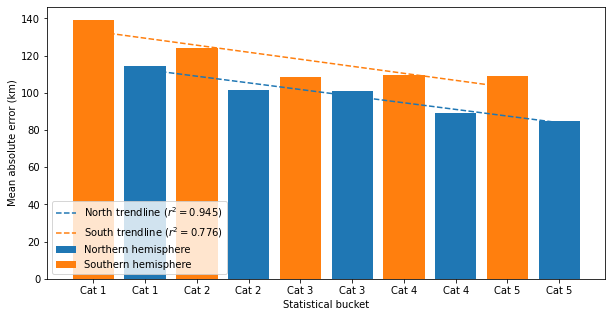

In [72]:
from sklearn.metrics import r2_score

plt.gcf().set_size_inches(10, 5)

N_ticks = np.arange(len(bars[1]))*2+1
plt.bar(N_ticks, bars[1], label='Northern hemisphere')
pN = np.poly1d(np.polyfit(N_ticks, bars[Hemisphere.North], 1))
plt.plot(N_ticks, pN(N_ticks), linestyle='--', label=f'North trendline ($r^2={r2_score(bars[1], pN(N_ticks)):.3f}$)')

S_ticks = np.arange(len(bars[0]))*2
plt.bar(S_ticks, bars[0], label='Southern hemisphere')
pS = np.poly1d(np.polyfit(S_ticks, bars[Hemisphere.South], 1))
plt.plot(S_ticks, pS(S_ticks), linestyle='--', label=f'South trendline ($r^2={r2_score(bars[0], pS(S_ticks)):.3f}$)')

plt.ylabel("Mean absolute error (km)")
plt.xlabel("Statistical bucket")
plt.gca().set_xticks(np.arange(len(labels)))
plt.gca().set_xticklabels(labels)

plt.legend(loc="lower left")

plt.savefig("acc_by_category.png", dpi=300)

None